# Workshop #2. Expression quantification

# Hometask

## Task 1

Please, provide an example where even EM-based algorithm estimates expression wrong. Describe in which exact cases it might happens.

В общем случае неправильная оценка получается, решение не единственно.
К этому может привести:
- Слишком неразличимые данные (пример 1.0)
- Самопересечения транскриптов (пример 1.1)
- Слишком малое кол-во данных (пример 2)


А также технические факторы:
- Неправильный выбор распределений
- Некорректная инициализация параметров распределений
- Искуственное ограничение кол-ва шагов (и вообще неправильный выбор критерия конвергенции)

In [70]:
def EM(transcripts, reads):
  # Works for an example with k = 1 and read_length = 1 — the simplest case

  length = np.array([len(i) for i in transcripts])
  length_factors = length / min(length)

  # Transcripts counts estimation
  def expectation(transcripts, reads, abundance):
    counts = np.zeros(len(transcripts))
    for i, read in enumerate(reads):
      equivalence_class = np.array([
          read in transcript for transcript in transcripts
      ]) # From which transcript our read might be?
      counts[equivalence_class] += (
          abundance[equivalence_class] / sum(abundance[equivalence_class])
      ) # Add fraction of the read to the transcripts according their abundances

    counts = np.round(counts, 3)
    return counts

  # Abundances maximization
  def maximization(counts, length_factors):
    abundance = (counts / sum(counts)) / length_factors # Taking into account
    # length factor
    abundance = abundance / sum(abundance)
    return abundance

  # Initianion
  abundance = np.ones(len(transcripts)) / len(transcripts) # Equal amount
  counts = expectation(transcripts, reads, abundance)

  # EM steps
  prev_counts = np.zeros(len(transcripts))
  step = 0
  while list(prev_counts) != list(counts) and step != 100: # Until convergence or step == 100
    # if step % 10 == 0: print(step)
    step += 1
    prev_counts = counts.copy()
    abundance = maximization(counts, length_factors)
    counts = expectation(transcripts, reads, abundance)

  return (abundance, counts, step)

In [71]:
# Пример 1.0 Сильное взаимное пересечение
# В приведенном примере транскрипты изначально очень сильно пересекаются
# Пришлость останавливать EM на 100 шаге, так как он не сходился

import random
import numpy as np

seed = 1

transcripts = [
    "12345",
    "23456",
    "34567",
    "45671",
    "56712",
    "67123",
    "71234"
]

random.seed(seed)
n_molecules = [random.randint(30, 1000) for i in transcripts]
abundance_ground_truth = np.array(
    [n_molecules[i] / sum(n_molecules) for i in range(len(n_molecules))]
)

print("\n".join([
    f"{transcripts[i]}: {n_molecules[i]} ({(abundance_ground_truth[i] * 100):.2f}%)"
    for i in range(len(n_molecules))
]))

frac_reads = 0.1

random.seed(seed)
letters_pool = "".join([
    transcripts[i] * n_molecules[i]
    for i in range(len(transcripts))
])
reads = random.sample(letters_pool, int(frac_reads * len(letters_pool)))
print(f"We have {frac_reads * 100}% of transcripts in our pool ({len(reads)})")

abundance, counts, step = EM(transcripts, reads)

print("Differences in abundance (in %):")
print((abundance - abundance_ground_truth) * 100)

12345: 167 (4.48%)
23456: 612 (16.43%)
34567: 897 (24.09%)
45671: 851 (22.85%)
56712: 812 (21.80%)
67123: 94 (2.52%)
71234: 291 (7.81%)
We have 10.0% of transcripts in our pool (1862)
Differences in abundance (in %):
[ 3.96186896  2.6764232  -2.92153598  4.19640172 -4.59779807  2.14881847
 -5.4641783 ]


In [74]:
# Пример 1.1 Сильное самопересечение
# В приведенном примере первый транскрипт самопересекается
import random
import numpy as np

seed = 1

transcripts = [
    "1234512345",
    "23456",
    "34567",
    "45671",
    "56712",
    "67123",
    "71234"
]

random.seed(seed)
n_molecules = [random.randint(30, 1000) for i in transcripts]
abundance_ground_truth = np.array(
    [n_molecules[i] / sum(n_molecules) for i in range(len(n_molecules))]
)

print("\n".join([
    f"{transcripts[i]}: {n_molecules[i]} ({(abundance_ground_truth[i] * 100):.2f}%)"
    for i in range(len(n_molecules))
]))

frac_reads = 0.1

random.seed(seed)
letters_pool = "".join([
    transcripts[i] * n_molecules[i]
    for i in range(len(transcripts))
])
reads = random.sample(letters_pool, int(frac_reads * len(letters_pool)))
print(f"We have {frac_reads * 100}% of transcripts in our pool ({len(reads)})")

abundance, counts, step = EM(transcripts, reads)

print("Differences in abundance (in %):")
print((abundance - abundance_ground_truth) * 100)

1234512345: 167 (4.48%)
23456: 612 (16.43%)
34567: 897 (24.09%)
45671: 851 (22.85%)
56712: 812 (21.80%)
67123: 94 (2.52%)
71234: 291 (7.81%)
We have 10.0% of transcripts in our pool (1945)
Differences in abundance (in %):
[-4.48439964  8.645139   -7.95789882  5.65784944 -4.64568939  0.12765831
  2.6573411 ]


In [73]:
# Пример 2 Слишком мало данных
# В приведенном примере мы берем слишком маленькую долю прочтений

import random
import numpy as np

seed = 1

transcripts = [
    "1242353",
    "523405",
    "943875"
]

random.seed(seed)
n_molecules = [random.randint(30, 1000) for i in transcripts]
abundance_ground_truth = np.array(
    [n_molecules[i] / sum(n_molecules) for i in range(len(n_molecules))]
)

print("\n".join([
    f"{transcripts[i]}: {n_molecules[i]} ({(abundance_ground_truth[i] * 100):.2f}%)"
    for i in range(len(n_molecules))
]))

frac_reads = 0.001

random.seed(seed)
letters_pool = "".join([
    transcripts[i] * n_molecules[i]
    for i in range(len(transcripts))
])
reads = random.sample(letters_pool, int(frac_reads * len(letters_pool)))
print(f"We have {frac_reads * 100}% of transcripts in our pool ({len(reads)})")

abundance, counts, step = EM(transcripts, reads)

print("Differences in abundance (in %):")
print((abundance - abundance_ground_truth) * 100)

1242353: 167 (9.96%)
523405: 612 (36.52%)
943875: 897 (53.52%)
We have 0.1% of transcripts in our pool (10)
Differences in abundance (in %):
[ -9.96420048 -16.51551313  26.4797136 ]


## Task 2

Using [recount3](https://rna.recount.bio/), find any available RNA-Seq dataset (only one sample will be enough) with already estimated expressions at the level of gene counts. Re-estimate the expressions with `kallisto` and compare the results (at the gene level).

#### 1. Устанавливаем recount3 и скачиваем случайный проект с одним образцом

In [ ]:
%load_ext rpy2.ipython
%R .libPaths("usr/local/lib/R/site-library/")
!Rscript -e 'install.packages("BiocManager")'
!Rscript -e 'BiocManager::install("recount3")'

In [8]:
%%R
suppressPackageStartupMessages({library(recount3)})

In [ ]:
%%R
human_projects <- available_projects()

proj_info <- subset(human_projects, project == "SRP031765" & project_type == "data_sources")
rse <- create_rse(proj_info)

counts_df <- as.data.frame(assays(rse)$raw_counts)
write.csv(counts_df, "recount3_data.csv")
rse

#### 2. Устанавливаем kallisto, скачиваем и и ндексируем референсный транскриптом, скачиваем сырые прочтения и запускаем kallisto

In [ ]:
!git clone https://github.com/pachterlab/kallisto.git
!apt-get install autoconf
!cd kallisto && mkdir build && cd build && cmake .. && make

In [ ]:
!wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_26/gencode.v26.transcripts.fa.gz
!gunzip gencode.v26.transcripts.fa.gz
!./kallisto/build/src/kallisto index -i gencode.v26.transcripts.fa.idx gencode.v26.transcripts.fa

In [10]:
# !wget https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/3.1.1/sratoolkit.3.1.1-ubuntu64.tar.gz
# !tar -xzf sratoolkit.3.1.1-ubuntu64.tar.gz
!sratoolkit.3.1.1-ubuntu64/bin/fasterq-dump SRR1014665

spots read      : 2,500
reads read      : 5,000
reads written   : 2,500
reads 0-length  : 2,500


In [11]:
!./kallisto/build/src/kallisto quant -i gencode.v26.transcripts.fa.idx -o results --single -l 90 -s 1 SRR1014665.fastq


[quant] fragment length distribution is truncated gaussian with mean = 90, sd = 1
[index] k-mer length: 31
[index] number of targets: 199,324
[index] number of k-mers: 125,322,840
[quant] running in single-end mode
[quant] will process file 1: SRR1014665.fastq
[quant] finding pseudoalignments for the reads ... done
[quant] processed 2,500 reads, 2,267 reads pseudoaligned
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 465 rounds



#### 3. Сравниваем результаты recount3 и kallisto

In [4]:
import pandas as pd
kallisto_data = pd.read_csv("results/abundance.tsv", sep="\t")
kallisto_data['gene_id'] = kallisto_data['target_id'].apply(lambda x: x.split('|')[1])

kallisto_data = kallisto_data.groupby('gene_id')['tpm'].sum()
kallisto_data = kallisto_data.to_frame().reset_index()
kallisto_data

,gene_id,tpm
0,ENSG00000000003.14,0.0000
1,ENSG00000000005.5,0.0000
2,ENSG00000000419.12,0.0000
3,ENSG00000000457.13,60.6517
4,ENSG00000000460.16,0.0000
...,...,...
58214,ENSG00000284592.1,0.0000
58215,ENSG00000284594.1,0.0000
58216,ENSG00000284595.1,0.0000
58217,ENSG00000284596.1,0.0000


In [5]:
recount3_data = pd.read_csv("recount3_data.csv").rename(columns={'Unnamed: 0':'gene_id','SRR1014665':'counts'})
recount3_data

,gene_id,counts
0,ENSG00000278704.1,0
1,ENSG00000277400.1,0
2,ENSG00000274847.1,0
3,ENSG00000277428.1,0
4,ENSG00000276256.1,0
...,...,...
63851,ENSG00000124334.17_PAR_Y,0
63852,ENSG00000185203.12_PAR_Y,0
63853,ENSG00000270726.6_PAR_Y,0
63854,ENSG00000182484.15_PAR_Y,0


In [6]:
recount3_data['gene_id'].isin(kallisto_data['gene_id']).value_counts()
# Видимо, для recount3 был использован другой более полный референс, так как там на 5637 больше записей. Для корректного сравнения tpm посчитаем без них

gene_id
True     58219
False     5637
Name: count, dtype: int64

In [7]:
recount3_data = recount3_data[recount3_data['gene_id'].isin(kallisto_data['gene_id'])]
recount3_data['tpm'] = recount3_data['counts'] / recount3_data['counts'].sum() * 1e6
recount3_data = recount3_data.drop(columns=['counts'])
recount3_data

<ipython-input-7-93d39f712aa0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recount3_data['tpm'] = recount3_data['counts'] / recount3_data['counts'].sum() * 1e6


,gene_id,tpm
5637,ENSG00000223972.5,0.0
5638,ENSG00000278267.1,0.0
5639,ENSG00000227232.5,0.0
5640,ENSG00000284332.1,0.0
5641,ENSG00000243485.5,0.0
...,...,...
63851,ENSG00000124334.17_PAR_Y,0.0
63852,ENSG00000185203.12_PAR_Y,0.0
63853,ENSG00000270726.6_PAR_Y,0.0
63854,ENSG00000182484.15_PAR_Y,0.0


In [33]:
# Посмотрим на данные
print(
    kallisto_data['tpm'].value_counts(),
    recount3_data['tpm'].value_counts(),
    sep="\n===========================\n", end="\n\n")

# И проверим, что суммы сходятся
print(
    kallisto_data['tpm'].sum(),
    recount3_data['tpm'].sum(),
    sep="\n===========================\n")

# Ну, порядки вроде сходятся -- можно смотреть корреляцию и строить график. Суммы тоже в порядке :)

tpm
0.000000       56872
809.764000         4
1017.620000        4
764.235000         4
535.287000         4
               ...  
649.470000         1
366.656000         1
275.780482         1
440.497000         1
103.475000         1
Name: count, Length: 1227, dtype: int64
tpm
0.000000       56728
418.334193       934
413.686036       134
836.668386        91
409.037878        42
               ...  
376.500774         1
60.426050          1
139.444731         1
204.518939         1
2031.244916        1
Name: count, Length: 133, dtype: int64

1000000.1011408312
1000000.0


0.814733734579549 0.9137762342476021


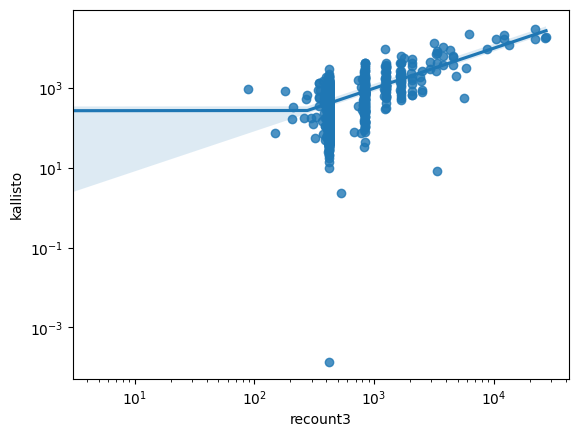

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

data = kallisto_data.merge(recount3_data[['gene_id', 'tpm']], on='gene_id').rename(columns={'tpm_x':'kallisto','tpm_y':'recount3'})
print(
    data['recount3'].corr(data['kallisto'], method='pearson'),
    data['recount3'].corr(data['kallisto'], method='spearman'))
sns.regplot(data, x='recount3', y='kallisto')
plt.yscale('log')
plt.xscale('log')

Корреляция замечательная: 0.814733734579549 -- Пирcон, 0.9137762342476021 -- Спирман

In [29]:
# Есть какая-то странная точка на графике, для которой tpm у kallisto < 10^-3
print(
    kallisto_data.query('tpm < 10e-3 & tpm > 0'),
    recount3_data.query('gene_id == "ENSG00000242616.3"'),
    sep="\n===========================\n")

# При этом recoun3 дает довольно высокую оцкнку -- 418 tpm
# ENSG00000242616.3 – https://www.ensembl.org/Homo_sapiens/Gene/Summary?g=ENSG00000242616;r=9:111661605-111670226;t=ENST00000374293
# Думаю, что дело в том, что у данного гена 11 паралогов

                 gene_id       tpm
36648  ENSG00000242616.3  0.000135
42049  ENSG00000254206.5  0.001393
                 gene_id         tpm
60229  ENSG00000242616.3  418.334193


Text(0, 0.5, 'TPM')

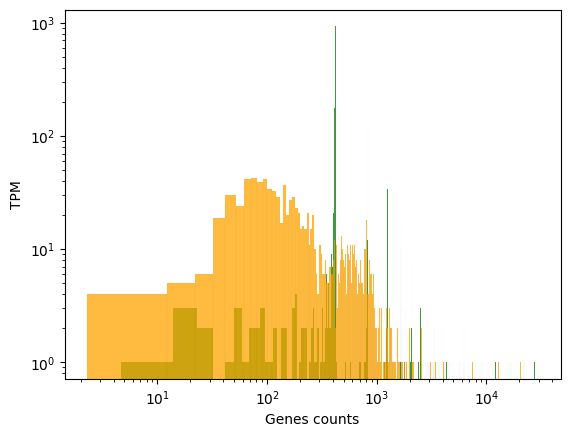

In [51]:
# Также интересно, что у recount3 видно явную неравномерность распределения tpm – вертикальные полосы на графике
# На гистограммах видно, что kallisto занижает оценку относительно recount3, а recount3 дает очень "рваное" распраделение

sns.histplot(data[data['recount3'] > 1]['recount3'], bins=3000, color='green')
sns.histplot(data[data['kallisto'] > 1]['kallisto'], bins=3000, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Genes counts')
plt.ylabel('TPM')